In [1]:
from utils import *
import pandas as pd
from astropy.time import Time
from rich.progress import Progress, TimeElapsedColumn
from astroplan.plots import plot_schedule_airmass
from matplotlib import pyplot as plt

from astroplan import Observer, AirmassConstraint, AtNightConstraint, Transitioner, SequentialScheduler, Schedule, \
    TimeConstraint, ObservingBlock, FixedTarget, PriorityScheduler

import numpy as np

location = EarthLocation(lat=43.82416667 * u.deg, lon=126.331111 * u.deg, height=313 * u.m)
observer = Observer(location)
observing_date = Time('2023-06-08')

obs_start = observer.twilight_evening_astronomical(time=observing_date, which='next')
obs_end = observer.twilight_morning_astronomical(time=obs_start, which='next')



In [2]:
from astropy.coordinates import SkyCoord
from astropy import units as u

from sqlalchemy import create_engine

engine = create_engine('sqlite:///ossaf/data/tyc2.sqlite', echo=False)
conn = engine.connect()
writer_conn = engine.connect()

In [3]:
# Get tycho stars
limit_magnitude = 8
tycho = pd.read_sql_query(f"SELECT * FROM tyc2 WHERE VTmag < {limit_magnitude}", con=conn, chunksize=2000)

In [4]:
for chunk in tycho:
    tycho_skycoord = SkyCoord(ra=chunk.RA_ICRS_.to_numpy() * u.deg, dec=chunk.DE_ICRS_.to_numpy() * u.deg, frame='icrs')
    target = FixedTarget(coord=tycho_skycoord, name=chunk.ID)

    tycho_rise_time = observer.target_rise_time(obs_start, target, which='next', horizon=30 * u.deg)
    # print(tycho_rise_time)

    visible_star = chunk.loc[tycho_rise_time < obs_end].copy()

    visible_star['priority'] = np.random.randint(1, 5, size=len(visible_star))
    visible_star['rise_time'] = tycho_rise_time[tycho_rise_time < obs_end].datetime

    date_string = observing_date.strftime("%Y_%m_%d")
    visible_star.to_sql(f"rise_in_night_{date_string}1", con=conn, if_exists='append', index=False)


In [ ]:
conn.close()

In [65]:
date_string = observing_date.strftime("%Y_%m_%d")
visible_stars = pd.read_sql_query(f"SELECT * FROM rise_in_night_{date_string}1 ", con=conn)

visible_stars = visible_stars.sample(100)
visible_stars.to_sql(f"candidate_{date_string}", con=conn, if_exists='replace', index=False)

visible_icrs = SkyCoord(ra=visible_stars.RA_ICRS_.to_numpy() * u.deg, dec=visible_stars.DE_ICRS_.to_numpy() * u.deg,
                        frame='icrs')
print(len(visible_icrs))

100


In [81]:
# 观测块
blocks = []
for star, name, p, (_, v) in zip(visible_icrs, visible_stars.ID, visible_stars.priority, visible_stars.iterrows()):
    target = FixedTarget(coord=star, name=name)

    b = ObservingBlock(target, 5 * u.min, priority=p)
    blocks.append(b)

    print(star, v.rise_time, p)

<SkyCoord (ICRS): (ra, dec) in deg
    (340.48917556, 14.5164425)> 2023-06-08 17:01:30.474719 2
<SkyCoord (ICRS): (ra, dec) in deg
    (297.75628194, 10.41604583)> 2023-06-08 14:27:16.912157 2
<SkyCoord (ICRS): (ra, dec) in deg
    (305.66713722, -5.08114528)> 2023-06-08 16:16:25.966757 3
<SkyCoord (ICRS): (ra, dec) in deg
    (274.35838306, -14.84899111)> 2023-06-08 15:51:21.214468 3
<SkyCoord (ICRS): (ra, dec) in deg
    (341.67654056, 53.63942528)> 2023-06-08 14:43:55.188657 1
<SkyCoord (ICRS): (ra, dec) in deg
    (283.25748806, -9.57555583)> 2023-06-08 15:21:10.331593 1
<SkyCoord (ICRS): (ra, dec) in deg
    (265.4399775, -13.31556722)> 2023-06-08 14:50:51.221685 4
<SkyCoord (ICRS): (ra, dec) in deg
    (308.04263667, 15.88266306)> 2023-06-08 14:47:03.751746 2
<SkyCoord (ICRS): (ra, dec) in deg
    (356.76412722, 58.65186)> 2023-06-08 15:18:47.111086 3
<SkyCoord (ICRS): (ra, dec) in deg
    (311.21884, 25.27103556)> 2023-06-08 14:26:27.670822 2
<SkyCoord (ICRS): (ra, dec) in deg
 

In [82]:
# create the list of constraints that all targets must satisfy
global_constraints = [AirmassConstraint(max=3, boolean_constraint=False),
                      AtNightConstraint.twilight_astronomical()]

slew_rate = 3 * u.deg / u.second  # 1.2M 最大转速是 6 deg/s
transitioner = Transitioner(slew_rate,
                            {'filter': {('B', 'G'): 10 * u.second,
                                        ('G', 'R'): 10 * u.second,
                                        'default': 30 * u.second}})



In [83]:
schedule = Schedule(obs_start, obs_end)

In [84]:
priority_scheduler = PriorityScheduler(constraints=global_constraints,
                                       observer=observer,
                                       transitioner=transitioner)

In [85]:
priority_scheduler(blocks, schedule)

Schedule containing 41 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

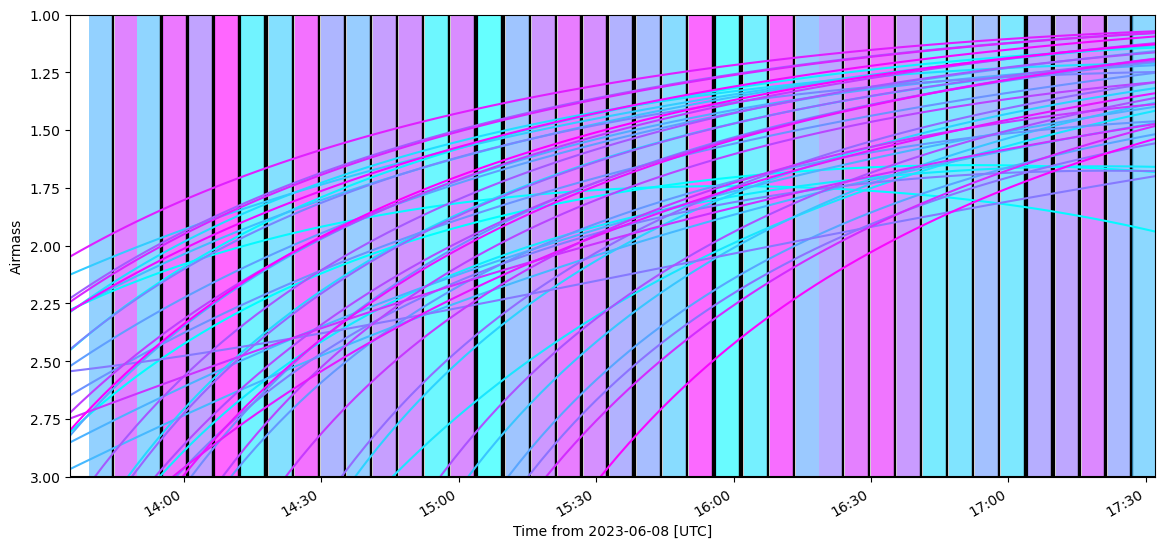

In [86]:

schedule.to_table()

# plot the schedule with the airmass of the targets
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule)
# plt.legend(loc="upper right")
plt.show()

In [87]:
schedule.to_table()

target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
str15,str23,str23,float64,str32,str32,object
4013-1825-1,2023-06-08 13:39:16.683,2023-06-08 13:44:16.683,5.000000000000142,356.76412722,58.65186,{}
TransitionBlock,2023-06-08 13:44:16.683,2023-06-08 13:44:36.683,0.33333333333327886,,,[]
4019-3357-1,2023-06-08 13:44:56.684,2023-06-08 13:49:56.684,5.000003054738045,4.61992778,62.20280361,{}
3664-1016-1,2023-06-08 13:49:56.684,2023-06-08 13:54:56.684,5.000000000000142,2.88910056,59.76213667,{}
TransitionBlock,2023-06-08 13:54:56.684,2023-06-08 13:55:16.684,0.33333333333327886,,,[]
2145-643-1,2023-06-08 13:55:36.684,2023-06-08 14:00:36.684,5.000000000000142,300.02741056,25.95006833,{}
TransitionBlock,2023-06-08 14:00:36.684,2023-06-08 14:00:56.684,0.33333333333327886,,,[]
1633-2180-1,2023-06-08 14:01:16.684,2023-06-08 14:06:16.684,5.000000000000142,308.04263667,15.88266306,{}
TransitionBlock,2023-06-08 14:06:16.684,2023-06-08 14:06:36.684,0.33333333333327886,,,[]


In [88]:
def schedule2df_ex(schedule: Schedule):
    columns = ['name',
               'start',
               'end',
               'RA_ICRS_',
               'DE_ICRS_',
               'priority']

    schedule_df = pd.DataFrame(
        columns=columns)

    for slot in schedule.slots:
        if hasattr(slot.block, 'target'):
            start_times = slot.start.iso
            end_times = slot.end.iso
            target_names = slot.block.target.name
            ra = slot.block.target.ra.value
            dec = slot.block.target.dec.value
            # config = slot.block.configuration
            priority = slot.block.priority
        else:
            continue

        tmp = pd.Series([target_names, start_times, end_times, ra, dec, priority],
                        index=columns
                        )
        schedule_df = pd.concat([schedule_df, tmp.to_frame().T], ignore_index=True)
    schedule_df = schedule_df.infer_objects()
    schedule_df['name'] = schedule_df['name'].astype(str)
    schedule_df['start'] = schedule_df['start'].astype('datetime64')
    schedule_df['end'] = schedule_df['end'].astype('datetime64')

    schedule_df = schedule_df.sort_values('start')

    return schedule_df

In [89]:
x = schedule2df_ex(schedule)

In [90]:
print(x)

           name                   start                     end    RA_ICRS_  \
0   4013-1825-1 2023-06-08 13:39:16.683 2023-06-08 13:44:16.683  356.764127   
1   4019-3357-1 2023-06-08 13:44:56.684 2023-06-08 13:49:56.684    4.619928   
2   3664-1016-1 2023-06-08 13:49:56.684 2023-06-08 13:54:56.684    2.889101   
3    2145-643-1 2023-06-08 13:55:36.684 2023-06-08 14:00:36.684  300.027411   
4   1633-2180-1 2023-06-08 14:01:16.684 2023-06-08 14:06:16.684  308.042637   
5   2174-2867-1 2023-06-08 14:06:56.684 2023-06-08 14:11:56.684  311.218840   
6   5693-5307-1 2023-06-08 14:12:36.685 2023-06-08 14:17:36.685  283.027478   
7   3616-1547-1 2023-06-08 14:18:36.685 2023-06-08 14:23:36.685  326.643279   
8   2717-1199-1 2023-06-08 14:24:16.685 2023-06-08 14:29:16.685  324.058403   
9     476-283-1 2023-06-08 14:29:56.685 2023-06-08 14:34:56.685  289.831457   
10  1062-2701-1 2023-06-08 14:35:36.686 2023-06-08 14:40:36.686  297.756282   
11   2168-885-1 2023-06-08 14:41:16.686 2023-06-08 1

In [91]:
x.to_sql(f"priority_schedule_{date_string}", con=conn, if_exists='replace', index=False)

41

In [95]:
seq_scheduler = SequentialScheduler(constraints=global_constraints,
                                         observer=observer,
                                         transitioner=transitioner)

schedule = Schedule(obs_start, obs_end)
seq_scheduler(blocks, schedule)


Schedule containing 46 observing blocks between 2023-06-08 13:35:16.683 and 2023-06-08 17:32:01.974

In [96]:
schedule.to_table()

target,start time (UTC),end time (UTC),duration (minutes),ra,dec,configuration
str15,str23,str23,float64,str32,str32,object
2145-643-1,2023-06-08 13:35:16.683,2023-06-08 13:40:16.683,5.000000000000142,300.02741056,25.95006833,{}
TransitionBlock,2023-06-08 13:40:16.683,2023-06-08 13:40:18.149,0.02443313712088724,,,[]
1627-3159-1,2023-06-08 13:40:18.149,2023-06-08 13:45:18.149,5.000000000000142,297.67313139,22.11292139,{}
TransitionBlock,2023-06-08 13:45:18.149,2023-06-08 13:45:21.045,0.048254527237521216,,,[]
2167-1353-1,2023-06-08 13:45:21.045,2023-06-08 13:50:21.045,4.999999999999982,304.16439333,28.52292278,{}
TransitionBlock,2023-06-08 13:50:21.045,2023-06-08 13:50:30.681,0.1606101607530519,,,[]
3616-1547-1,2023-06-08 13:50:30.681,2023-06-08 13:55:30.681,5.000000000000142,326.64327944,52.12415583,{}
TransitionBlock,2023-06-08 13:55:30.681,2023-06-08 13:55:44.070,0.2231470765438459,,,[]
1623-2647-1,2023-06-08 13:55:44.070,2023-06-08 14:00:44.070,5.000000000000142,297.24437056,19.14198083,{}


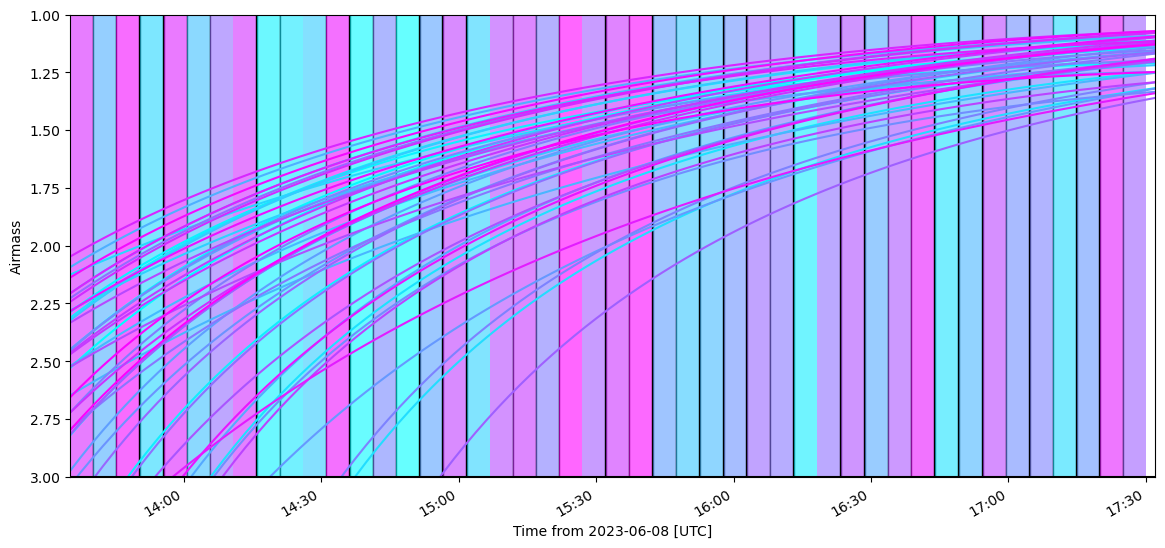

In [97]:

schedule.to_table()

# plot the schedule with the airmass of the targets
plt.figure(figsize=(14, 6))
plot_schedule_airmass(schedule)
# plt.legend(loc="upper right")
plt.show()

In [98]:
x = schedule2df_ex(schedule)
x.to_sql(f"sequential_schedule_{date_string}", con=conn, if_exists='replace', index=False)


46